# **5. Modelos ARIMA Sazonais e com Variáveis Exógenas** 
___


Neste capítulo você vai aprender sobre:

* Ajustar modelos ARIMA para dados com efeitos de sazonalidade
* Levar em conta o efeito de variáveis exógenas
* Introduzir variáveis exógenas para o melhor ajuste de modelos ARIMA 

## Modelos SARIMA

Nos capítulos anteriores você aprendeu como modelar séries temporais por meio dos modelos ARIMA. A classe de modelos ARIMA assume entre outras premissas básicas que a série temporal estudada é estacionária, livre de tendência e sazonalidade. A estacionariedade de uma série pode ser verificada a partir do teste de Dickey Fuller, equanto que o efeito de sazonalidade pode ser visto através da visualização da decomposição entre tendência, sazonalidade e resíduo, ou identificada pelo próprio gráfico. Enquanto o efeito de estacionariedade pode ser removido através da diferenciação o efeito da sazonalidade precisa ser contabilizado caso a série assim se comporte. 
Uma parte bastante significativa das séries temporais no dia a dia apresentam efeitos de sazonalidade:
* Temperaturas diárias: se medirmos as temperaturas de hora em hora ao longo de um dia é bem provável que depois de alguns dias se observe um comportamento sazonal. 
* Vendas mensais: lojas do varejo frequentemente observam variações periódicas nas suas vendas principalmente em função de feriados ou promoções periódicas.
* Colheitas em agricultura: a produção agrícola segue um padrão sazonal dado que colheitas de produtos específicos acontecem em uma data específica do ano. 

Neste sentido podemos definir sazonalidade como sendo a tendência de um processo em se repetir dentro de um determinado período.
A partir deste contexto é fácil perceber que a hipótese de ausência de sazonalidade em uma série temporal pode representar uma limitação significativa para a modelagem com modelos ARIMA. Essa motivação levou à criação de uma nova classe de modelos denominados em inglês por *Seasonal Autoregressive Integrated Moving Average* (SARIMA). A motivação para esses modelos corresponde exatamente à tentativa de capturar os padrões nos dados que se repetem em intervalos periódicos, tais como dias, meses e anos. 

O modelo SARIMA inclui tanto componentes sazonais como componentes não sazonais. Desta forma, compreendendo em profundidade a modelagem SARIMA temos uma ferramenta poderosa de forecast que leva em conta elementos sazonais. 

De uma forma geral, um modelo SARIMA pode ser representado da seguinte forma:

$$SARIMA(p,d,q)(P,D,Q)_m$$

onde:

* p é a ordem da componente autoregressiva (AR) entre a série e os seus lags, e P tem o mesmo significado para a componente sazonal.
* d é o grau de diferenciação necessário para obter estacionariedade na série, D tem o mesmo significado para a componente sazonal. 
* q é a ordem da média móvel (MA), que modela a relação entre a série e os resíduos, e Q tem o mesmo significado para a componente sazonal. 
* m representa o período observado.

Vale notar que m, é um parâmetro que depende do intervalo de tempo dos dados. Se temos dados medidos ao longo de 30 dias (1 mês) e observamos uma sazonalidade com período de 7 dias, o valor de m será m=7, enquanto que se tivermos dados  mensais ao longo de 1 ano (12 meses) com sazonalidade mensal, o valor de m=1.

Neste ponto, vale a pena entendermos a equação que é ajustada em um modelo SARIMA. Utilizando a mesma notação do capítulo anterior temos que: 

$$
W_t^{'}=\underbrace{\Delta^d Y_t}_{\text {série após d diferenças }}
$$
o que define o parâmetro d. No caso da série se tornar estacionária após uma diferenciação (d=1), teríamos que $W_t^{'}=Y_t-Y_{t-1}$. No entanto, em uma série com sazonalidade eventualmente também precisamos diferenciar a série na componente sazonal e assim definir o parâmetro D, de tal forma que $W_t=Y_t-Y_{t-1m}$, onde $m$ é o período observado. Deste modo a equação para $W_t$ seria:

$$
W_t=c +(
\underbrace{\phi_1 W_{t-1}+\phi_2 W_{t-2}+\ldots+\phi_p W_{t-p}}_{\mathrm{p} \text { - termos autorregressivos }}+
\underbrace{\theta_1 e_{t-1}+\theta_2 e_{t-2}+\ldots+\theta_q e_{t-q}}_{\mathrm{q} \text { - termos de Médias moveis }})+
(\underbrace{\Phi_1 W_{t-1m}+\Phi_2 W_{t-2m}+\ldots+\Phi_p W_{t-Pm}}_{\mathrm{P} \text { - termos sazonais autorregressivos }}+
\underbrace{\Theta_1 e_{t-1m}+\Theta_2 e_{t-2m}+\ldots+\Theta_q e_{t-Qm}}_{\mathrm{Q} \text { - termos sazonais de Médias moveis }})+
e_t,
$$
em que $\phi_1, \ldots, \phi_p, \theta_1, \ldots, \theta_q,\Phi_1, \ldots, \Phi_p, \Theta_1, \ldots, \Theta_q$ são valores a serem estimados e $e_t$ é o ruído branco. A título de exemplo, um modelo SARIMA(2,0,3)$\times$(2,0,1,7), ajustaria a seguinte função:

$W_t=
c+
(\underbrace{\phi_1 W_{t-1}+\phi_2 W_{t-2}}_{\mathrm{p} \text { - termos autorregressivos }}+
\underbrace{\theta_1 e_{t-1}+\theta_2 e_{t-2}+\theta_3 e_{t-3}}_{\mathrm{q} \text { - termos de Médias moveis }})+
(\underbrace{\Phi_1 W_{t-(1\times7)}+\Phi_2 W_{t-(2\times7)}}_{\mathrm{P} \text { - termos sazonais autorregressivos }}+
\underbrace{\Theta_1 e_{t-(1\times7)}}_{\mathrm{Q} \text { - termos sazonais de Médias moveis }})+
e_t,
$

É fácil perceber matematicamente a relação entre os modelos ARIMA e os modelos SARIMA. Essa relação permanece ainda explícita quando ajustamos um modelo SARIMA em Python com o uso da biblioteca statsmodel.

### SARIMA com Python (hands-on) 

Vamos iniciar essa sessão intalando a biblioteca pmdarima. Essa biblioteca nos permite varrer um espaço de parâmetros para determinar a partir do Akaike Information Criteria (AIC) o melhor conjunto de parâmetros (p,d,q)(P,D,Q,m), conforme voltaremos mais adiante. Além disso, procedemos com os imports das componentes da biblioteca statsmodel já utilizadas anteriormente. A recomendação importante é rodar o comando pip install pmdarima, antes dos demais imports. O principal motivo é pelo fato de que ele instalará uma versão específica da biblioteca statsmodel (no geral a versão mais recente). 

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Resolvido o problema de dependência que comentamos, o ajuste e a previsão por meio de modelos SARIMA, pode ser entendido através das seguintes etapas descritas no fluxograma abaixo: 

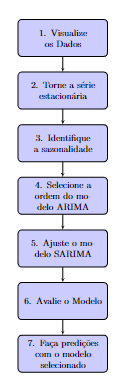


Entre as etapas estão:

1. **Visualizar os Dados:** Comece examinando os dados da série temporal e verificando se há tendências, sazonalidade ou valores discrepantes.

2. **Tornar a série Estacionária:** Se os dados não forem estacionários, realize a diferenciação para remover tendências e sazonalidade. Isso garantirá que os dados tenham média e variância constantes.

3. **Identificar a Sazonalidade:** Determine o período sazonal da série temporal. Isso ajudará na seleção dos parâmetros do modelo SARIMA.

4. **Selecionar a Ordem do modelo ARIMA:** Use os gráficos ACF e PACF para identificar as ordens do modelo ARIMA(p, d, q). O modelo SARIMA também incluirá componentes sazonais (P, D, Q).

5. **Ajustar o Modelo SARIMA:** Ajuste o modelo SARIMA usando as ordens e parâmetros identificados.

6. **Avaliar o Modelo:** Avalie o desempenho do modelo usando medidas estatísticas como erro médio quadrático (MSE), Critério de Informação Akaike (AIC) e Critério de Informação Bayesiano (BIC).

7. **Fazer Previsões:** Use o modelo SARIMA ajustado para fazer previsões para períodos futuros.


In [ ]:
#@markdown Bibliotecas básicas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(16,8))

In [ ]:
#@markdown Bibliotecas Time Series

import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as qqplot
import scipy.stats as stats

from pmdarima import auto_arima

In [ ]:
#@markdown `tspplot()`
def tspplot(ts=None,label=None,title=None,ax=None,linestyle='solid',alpha=1,lw=1,nr_xticks=None,nr_yticks=None):
  
  import matplotlib.ticker as ticker

  if ax is None:
    fig, ax = plt.subplots()
  
  if label is not None:
    ax.plot(ts, label=label, linestyle=linestyle, lw=lw)
  else:
    ax.plot(ts, linestyle=linestyle,lw=lw,alpha=alpha)

  if title is not None:
    ax.set_title(title)

  if nr_xticks is not None:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nr_xticks))

  if nr_yticks is not None:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nr_yticks))  
  
  if label is not None:
    plt.legend()

  plt.tight_layout()

  return

In [ ]:
#@markdown Caminho para os arquivos de dados
path = 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Data/'
plt.style.use([ 'grayscale' , 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/tsp.mplstyle' ])

In [ ]:
#@markdown `tspdisplay()`
class tspdisplay(object):
    # Adaptado de https://jakevdp.github.io/PythonDataScienceHandbook/index.html
    """Display HTML representation of multiple objects"""
    template = """
    
    {0}{1}
    """
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a + '.head()')._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a + '.head()'))
                           for a in self.args)


In [ ]:
#@markdown `tspsimulate()`
import ipywidgets as widgets
from statsmodels.tsa.seasonal import seasonal_decompose

def tspsimulate(nr_months=60, beta_0=1, beta_1=2, beta_2=0, beta_3=0, alpha=0.2, seasons_month_len=10, noise=0.2, model='additive', show_plot=False, title='TS Sample'):
  np.seed = 123
  index_dates = pd.date_range(start='1/1/2000', periods=nr_months, freq='M')

  t = np.arange(0,len(index_dates),1)
  n = len(t)

  T = beta_0 + beta_1*t + + beta_2*t**2 + beta_3*t**3
  S = np.sin( np.arange(0,len(index_dates),1) * 2 * np.pi/seasons_month_len)
  S = S # only positives values
  S = S * T.mean() * alpha # scale
  R = np.random.sample(n) 
  R = R # only positives values
  R = R * T.mean() * noise # scale

  if model == 'additive':
    Y = T + S + R  
  else:
    Y = T * S * R  
  
  Y = Y + np.abs(Y.min()) + 1 # just to create only positive values

  df = pd.DataFrame()
  df.index = index_dates
  df['t'], df['Y'], df['T'], df['S'], df['R'] = t, Y, T, S, R 

  global ts1
  ts1 = df

  decomp = seasonal_decompose(df.Y, model=model, period=seasons_month_len)

  if show_plot:
    fig = decomp.plot()
    fig.set_size_inches((9, 7))

    if title is not None:
      plt.suptitle(title,y=1.05)

    plt.tight_layout()
    plt.show()

  # plt.plot(df['T'])
  # plt.show()

  # plt.plot(df['S'])
  # plt.show()

  return ts1 

tspsimulate_ts = widgets.interactive(tspsimulate,  alpha=(0.2,10), beta_0=(-10,10), beta_1=(-10,10), beta_2=(-10,10), beta_3=(-10,10) ,nr_months=(40,120,1), seasons_month_len=(3, 12, 3), noise=(0, 1, 0.01), model=['additive','multiplicative'], show_plot=True)

In [ ]:
#@markdown `tspdecompose()`
def tspdecompose(df,model = 'multiplicative',title=None, period='7'):
  from statsmodels.tsa.seasonal import seasonal_decompose

  decomp = seasonal_decompose(df, model=model, period = period)

  fig = decomp.plot()
  fig.set_size_inches((9, 7))

  if title is not None:
    plt.suptitle(title,y=1.05)

  plt.tight_layout()
  plt.show()

  return

De modo a realizarmos o ajuste do modelo passo a passo, iremos nos basear no dados do Exercício 3 do capítulo 4, que utiliza o conjunto de dados Bike Sharing. O conjunto avalia os valores máximos de demandas de bicicleta por dia.  

In [ ]:
# ler os dados
df = pd.read_csv(path + "dados_bike.csv")
# verifica as 5 primeiras linhas
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year
0,2015-01-04,1039,4.0,3.5,100.0,15.0,4.0,0.0,1.0,3.0,2015
1,2015-01-05,3161,10.0,9.0,93.0,14.0,4.0,0.0,0.0,3.0,2015
2,2015-01-06,3534,11.0,11.0,88.0,27.5,7.0,0.0,0.0,3.0,2015
3,2015-01-07,3618,10.0,7.0,87.0,30.5,7.0,0.0,0.0,3.0,2015
4,2015-01-08,2351,12.0,12.0,88.0,27.0,7.0,0.0,0.0,3.0,2015


,timestamp,cnt,t1,t2,hum
0,2015-01-04,1039,4.0,3.5,100.0
1,2015-01-05,3161,10.0,9.0,93.0
2,2015-01-06,3534,11.0,11.0,88.0
3,2015-01-07,3618,10.0,7.0,87.0
4,2015-01-08,2351,12.0,12.0,88.0


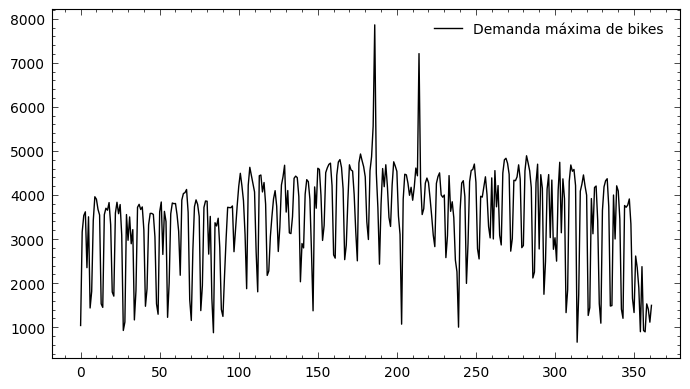

In [ ]:
# gráfico da série histórica com o dataframe
fig, ax = plt.subplots()

tspplot(df.cnt,label='Demanda máxima de bikes ',ax=ax)
tspdisplay("df.iloc[:, 0:5]")

Como já mencionado a série acima é um bom exemplo de um conjunto de dados históricos que pode eventualmente deixar dúvidas quando tentamos identificar se existe tendência apenas pelo gráfico. Apesar disso, a sazonalidade é evidente, assim como o período de 7 dias da série. Ainda assim, é importante mantermos no nosso repertório um conjunto de testes estatísticos que nos auxiliam a verificar as condições necessárias para o modelo. 

Neste tipo de caso procedemos com uma sequência de análises necessárias para a aplicação do modelo SARIMA através das seguintes etapas:

* Verificar a estacionariedade: usamos o teste de Dickey Fuller aumentado.
* Verificar sazonalidade: Usamos o plot da ACF e PACF.
* Definir os parâmetros (p,d,q)(P,D,Q,m): usaremos a biblioteca pmdarima para varrer o espaço de parâmetros.
* Fazer a previsão de valores: ajustamos o modelo com o melhor conjunto de parâmetros encontrados no passo anterior e na sequência fazemos a predição para o intervalo de tempo desejado.

A seguir executaremos cada uma das etapas mencionadas.

### Teste de estacionariedade
De modo a simplificar a nossa análise vamos transformar o teste aumentado de Dickey Fuller (adf_test) em uma função Python de modo a poder chamá-la diversas vezes. O código abaixo define a função desejada:

In [ ]:
from statsmodels.tsa.stattools import adfuller

#Definição da função
def adf_test(timeseries):
    # Realiza o teste de Dickey-Fuller
    print('Resultados do Testes de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Definida a função podemos utilizá-la para testar a série visualizada no gráfico acima. 

In [ ]:
adf_test(df['cnt'].dropna())

Resultados do Testes de Dickey-Fuller:
Test Statistic                  -0.698339
p-value                          0.847179
#Lags Used                      13.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


Observe, no entanto, que conforme poderíamos supor através do gráfico da coluna 'cnt', o teste evidencia que a função possui tendência. A tendência no entanto, pode ser eliminada através do processo de diferenciação como já comentado nos capítulos anteriores. Neste caso, repetimos o teste e observamos que o p-valor para a função diferenciada df['cnt'].diff() se torna menor que 0,05: 

In [ ]:
adf_test(df['cnt'].diff().dropna())

Resultados do Testes de Dickey-Fuller:
Test Statistic                -8.883419e+00
p-value                        1.299404e-14
#Lags Used                     1.200000e+01
Number of Observations Used    3.480000e+02
Critical Value (1%)           -3.449282e+00
Critical Value (5%)           -2.869881e+00
Critical Value (10%)          -2.571214e+00
dtype: float64


Dado que a função foi diferenciada uma única e com o lag=1, isso nos permitiu encontrar o valor de $d=1$. O ponto importante aqui no entanto, é que da mesma forma pudemos deduzir que $D=0$, dado que não foi necessário diferenciar a série em relação ao período de 7 dias de tal forma que a série se tornasse estacionária. Do ponto de vista das equações do início do capítulo, podemos entender esse processo como a necessidade de calularmos a diferença:

$$W_t^{'}=Y_t-Y_{t-1}$$ 

mas não a diferença:

$$W_t=Y_t-Y_{t-1×7}$$ 

para que a série se tornasse estacionária. Isso implica que para a série em questão, podemos assumir $d=1$ e $D=0$ para os parâmetros do nosso modelo SARIMA.

Vale aqui também recuperarmos os plots da ACF e PACF deste conjunto de dados, de modo a evidenciar as correlações entre os diferentes lags.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


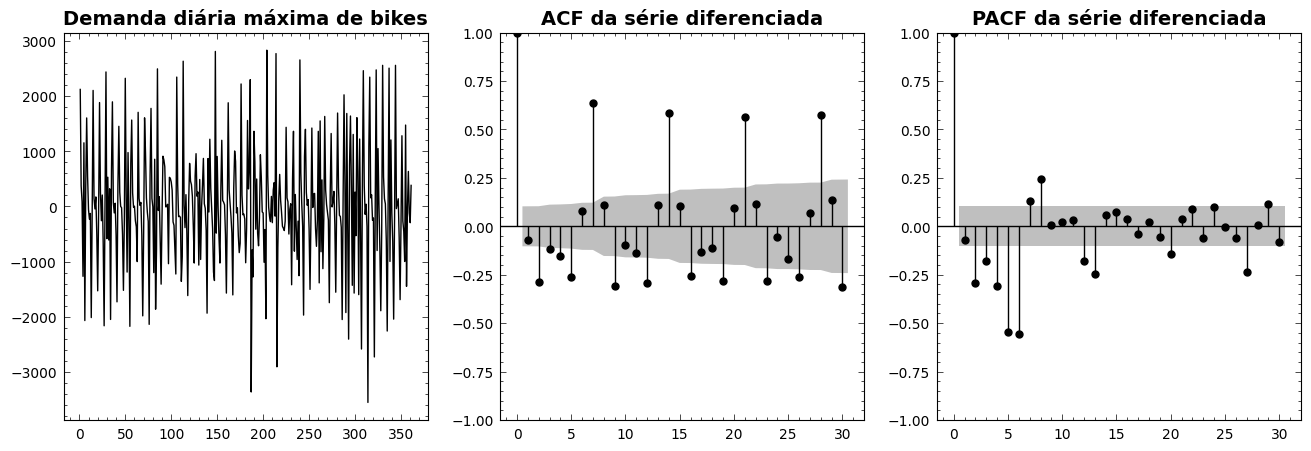

In [ ]:
# Analisando a ACF e PACF
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))

ax1.plot(df.cnt.diff(),linestyle='solid',alpha=1,lw=1)
ax1.set_title('Demanda diária máxima de bikes')

y1=plot_acf(df.cnt.diff().dropna(), lags=30, ax=ax2, title="ACF da série diferenciada");
y2=plot_pacf(df.cnt.diff().dropna(),ax=ax3, lags=30, title="PACF da série diferenciada");

Observando o gráfico acima, podemos entender agora que a função é fortemente correlacionada com os seus lags múltiplos de 7. Essa é uma forte evidência da sazonalidade e do valor de m=7. Note que dado que a série é sazonal, podemos diminuir a ordem dos termos autoregressivos de um modelo ARIMA e adicionar termos autoregressivos sazonais, preservando as informações do modelo. Em outras palavras, ao invés de utilizarmos $p=7$ como no modelo ARIMA ajustado no capítulo 4, nós podemos ajustar modelos de ordem p mais baixa como p=1 por exemplo, acrescentando no modelo os termos $P=1$ por exemplo que lidariam com o efeito da sazonalidade. Esse é o principal aspecto que difere modelos ARIMA e SARIMA. 

Continuando na sequência de passos acima para o ajuste do modelo SARIMA, passamos para a etapa de explorar diferentes parâmetros (p,q)x(P,Q) de modo a obter o melhor ajuste.

### Ajustando um modelo SARIMA: parâmetros (p,q)x(P,Q)
A biblioteca **pmdarima** foi construída em Python de modo a implementar o comando **auto.arima** da linguagem **R**. Esse comando  irá nos ajudar a varrer o espaço de parâmetros e encontrar os valores ótimos de (p,d,q)$\times$(P,D,Q)$_m$. De um modo geral, o comando tenta proceder a uma espécie de **grid search** experimentando vários valores de **p** e **q** (assim como das componentes sazonais **P** e **Q**) diferentes, definindo o melhor modelo a partir do menor valor do AIC (também é possível escolher a partir do BIC ou outro critério).

O uso do **auto-arima** é bastante simples, como pode ser visto no código a seguir:

In [ ]:
auto_arima(df['cnt'].dropna(),
           seasonal=True,
           max_p=2,max_q=2,max_P=2,max_Q=2,d=1,D=0,m=7,
           trace=True,
           stepwise=True,
           ).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=5.39 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=6075.081, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5829.230, Time=1.53 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5901.558, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6073.083, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=6075.478, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5779.900, Time=2.50 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5790.563, Time=6.86 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=5719.595, Time=3.61 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5958.751, Time=0.99 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5780.724, Time=5.86 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=5898.709, Time=2.67 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=6.46 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5796.153, Time=4.09 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -2827.576
Date:                           Tue, 04 Apr 2023   AIC                           5665.153
Time:                                   06:12:59   BIC                           5684.597
Sample:                                        0   HQIC                          5672.883
                                           - 362                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5220      0.637     -0.820      0.412      -1.770       0.726
ma.L1         -0.7447      0.034    -21.946      0.000      -0.811      -0.678
ar.S.L7        0.9943      0.004    240.423      0.000       0.986       1.002
ma.S.L7       -0.8396      0.029    -28.916      0.000      -0.896      -0.783
sigma2      3.508e+05   1.78e+04     19.714      0.000    3.16e+05    3.86e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.04   Jarque-Bera (JB):               120.82
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                            -0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Note que como parâmetros para a execução da função **auto_arima** passamos as opções seasonal=True, de modo que ele considere a possibilidade de uma série com sazonalidade e indicamos os valores máximos de p(max_p),q(max_q),P(max_P),Q(max_Q), assim como os valores de **d=1** e **D=0**. O principal motivo para essa escolha de parâmetros é que no geral o comando parte do pressuposto que a série em questão é estacionária e no nosso caso em particular verificamos através do teste de Dickey Fuller que a série só se tornava estacionária a partir de uma diferenciação com o lag 1. O parâmetro Trace=True permite que ao longo da execução possamos visualizar o conjunto de parâmetros testados e a opção stepwise utiliza um algoritmo interno da biblioteca que otimiza as buscas de parâmetros. Você pode encontrar mais detalhes dessas opções de parâmetros para o comando auto_arima no [link](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA). 

A partir do momento que temos uma boa escolha para os parâmetros **$(p,d,q)\times(P,D,Q)_m$**, podemos recorrer novamente à biblioteca **statsmodel**, de modo a ajustar o modelo, fazer a previsão para uma parte da série e assim avaliar através de alguma métrica, como MAE, ou RMSE, a qualidade do ajuste. 

## Ajustando o modelo SARIMA com a biblioteca STATSMODEL
Em seguida, utilizamos a função SARIMAX da biblioteca **statsmodel** para passar os parâmetros do modelo e procedermos com o ajuste. 

In [ ]:
#import do comando SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#declaração do modelo
model = SARIMAX(df['cnt'],order=(0,1,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)

#ajuste do modelo
results = model.fit()

In [ ]:
#resultados e métricas de avaliação
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               cnt   No. Observations:                  362
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -2830.610
Date:                           Tue, 04 Apr 2023   AIC                           5669.221
Time:                                   06:13:00   BIC                           5684.776
Sample:                                        0   HQIC                          5675.405
                                           - 362                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7397      0.034    -21.605      0.000      -0.807      -0.673
ar.S.L7        1.0000      0.000   5799.511      0.000       1.000       1.000
ma.S.L7       -0.9930      0.055    -18.017      0.000      -1.101      -0.885
sigma2      3.467e+05   1.59e-07   2.17e+12      0.000    3.47e+05    3.47e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):               213.71
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.43e+27. Standard errors may be unstable.
"""

Uma outra forma importante de avaliação e recomendada sempre que ajustamos um modelo ARIMA (ou SARIMAX), é através do comando **plot_diagnostics**. Este comando nos permite avaliar se as premissas que o modelo assume de aleatoriedade dos resíduos não foi violada:  

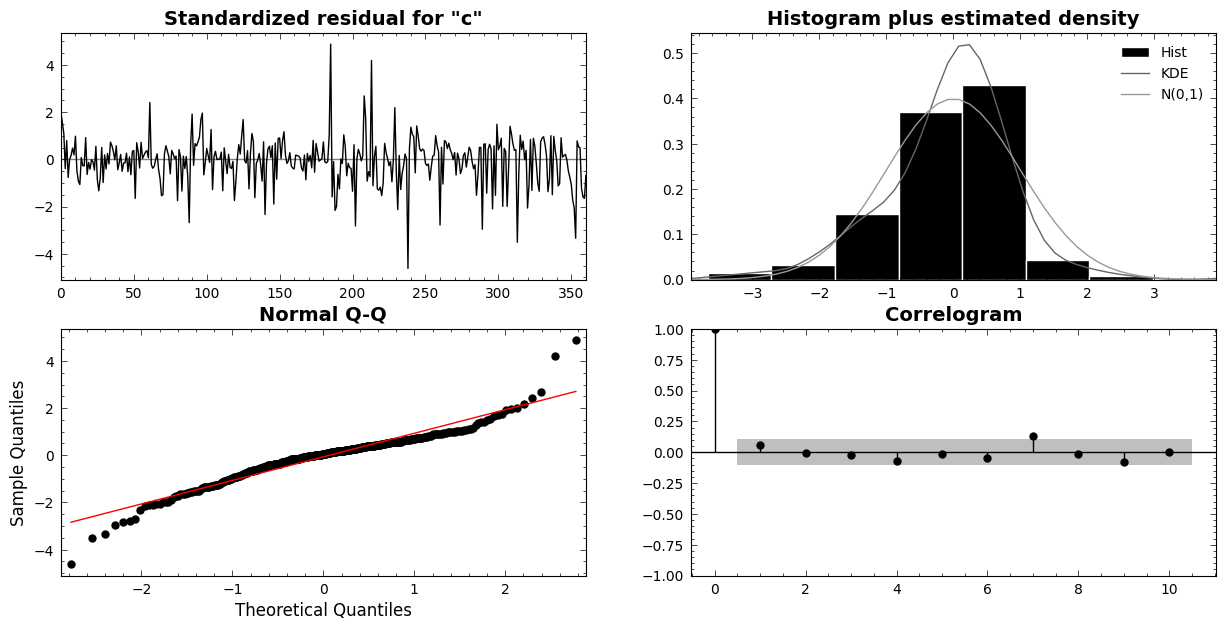

In [ ]:
results.plot_diagnostics(figsize=(14, 7))
plt.show()

As verificações importantes neste caso são as de que os resíduos seguem uma distribuição normal como pode ser visto através do histograma, correlograma e do gráfico Q-Q.

Dado os resultados acima, podemos proceder com a verificação dos resultados de qualidade de ajuste do modelo. No contexto das séries temporais, é oportuno comparar as previsões do modelo para um trecho final da série por exemplo. No código a seguir, calculamos qual o índice em que inicia os últimos 20% de dados da série histórica:

In [ ]:
#estimar o índice em que inicia os últimos 20% de
#dados da série, como o início do teste:
test_size = int(0.2*len(df))
train_size = len(df) - test_size
print(test)

290    2775
291    4461
292    4153
293    1747
294    2493
       ... 
357     894
358    1529
359    1409
360    1114
361    1496
Name: cnt, Length: 72, dtype: int64


Observe que o valor obtido é o índice 290. Dessa forma, podemos utilizar o comando get_prediction() que nos permite fazer previsões para esses últimos 20% valores da série e em seguida comparar aos resultados reais da série: 

In [ ]:
pred = results.get_prediction(start=290, dynamic=False)

Essa comparação pode ser feita graficamente, mas para isso é oportuno obter um dataframe com o intervalo de confiança para os valores previstos através do comando **pred.conf_int()** onde **pred** é o objeto que contém as previsões. Dessa forma podemos obter o intervalo de confiança executando:

In [ ]:
pred_ci = pred.conf_int()
pred_ci

,lower cnt,upper cnt
290,3370.399195,5698.647395
291,2914.938844,5243.161593
292,2597.270023,4925.478845
293,1433.858219,3761.990928
294,1074.217142,3402.108446
...,...,...
357,-559.214391,1764.047494
358,1093.122578,3416.285456
359,1189.138961,3512.247675
360,932.601306,3255.680385


Visualizando graficamente temos que:

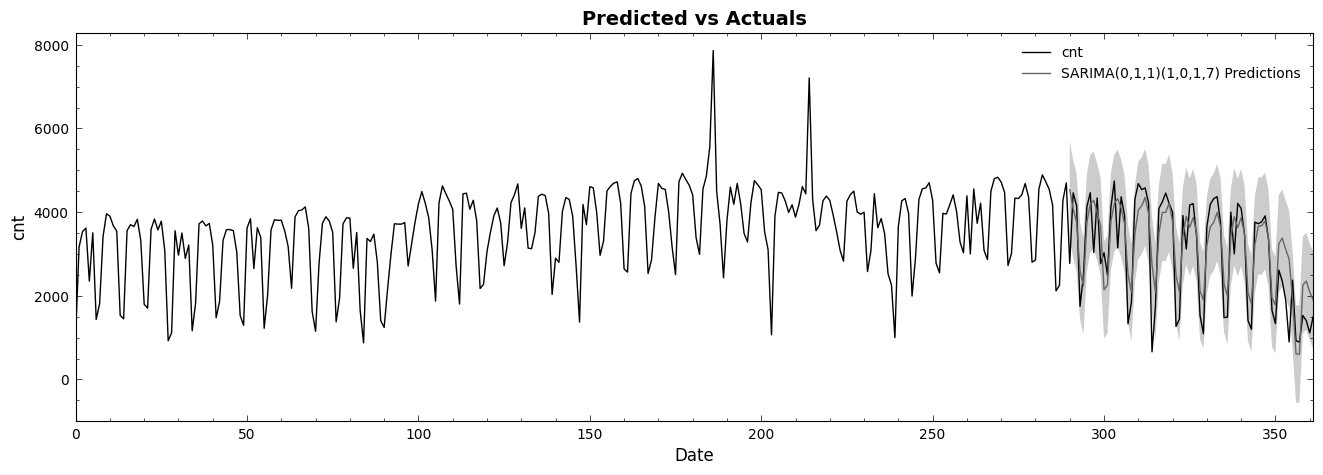

In [ ]:
ylabel='cnt'

ax = df['cnt'].plot(legend=True,figsize=(15,5))
pred.predicted_mean.rename('SARIMA(0,1,1)(1,0,1,7) Predictions').plot(legend=True)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)
ax.set_title('Predicted vs Actuals')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Apesar do ajuste parecer relativamente bom a partir da visualização do gráfico, é importante estimar o erro quadrático médio (MSE), assim como a sua raiz (RMSE), ou ainda o erro médio absoluto (MAE) de modo a comparar com o modelo ARIMA do capítulo anterior:

In [ ]:
from statsmodels.tools.eval_measures import mse,rmse, meanabs
reals = df[290:]['cnt']
error1 = mse(pred.predicted_mean, reals)
error2 = rmse(pred.predicted_mean, reals)
error3 = meanabs(pred.predicted_mean, reals)
print(f'SARIMA MSE Error: {error1:11.10}')
print(f'SARIMA RMSE Error: {error2:11.10}')
print(f'SARIMA MAE Error: {error3:11.10}')

SARIMA MSE Error: 505739.8367
SARIMA RMSE Error: 711.1538769
SARIMA MAE Error: 571.6280931


O importante é observar que o RMSE está na mesma unidade da série. Sendo assim, ele pode ser interpretado no caso como flutuações em relação à grandeza do eixo 'cnt'. No gráfico acima a escala do eixo y parece variar no intervalo de 500 a 8000. A flutuação de 711.15 é em torno de 9% dessa escala onde a variação ocorre, garantindo que o RMSE seja muito menor do que a variação entre os extremos do dado, o que é um excelente resultado significativo.

Ao mesmo tempo, vale ainda destacar que o modelo ARIMA(7,1,3) utilizado no capítulo 4 possui um valor de MAE de 539.02, enquanto que o modelo SARIMA(0,1,1)×(1,0,1,7) possui MAE de 571.63, que é ligeiramente mais elevado. Como a diferença é muito pequena, podemos considerar os modelos sob certo ponto de vista como equivalentes. 

### Realizando a previsão

Realizado todos os procedimentos acima, fazer a previsão de valores futuros que não estão na amostra (**forecast** em inglês), é trivial. A biblioteca statsmodel mantém a função **get_forecast** que recebe como argumento o número de pontos através do parâmetro **steps**. Nesse caso, para fazermos a previsão para os próximos 50 pontos futuros da série estudada, basta fazermos:

In [ ]:
pred_uc = results.get_forecast(steps=50)

# Intervalo de Confiança
pred_ci = pred_uc.conf_int()

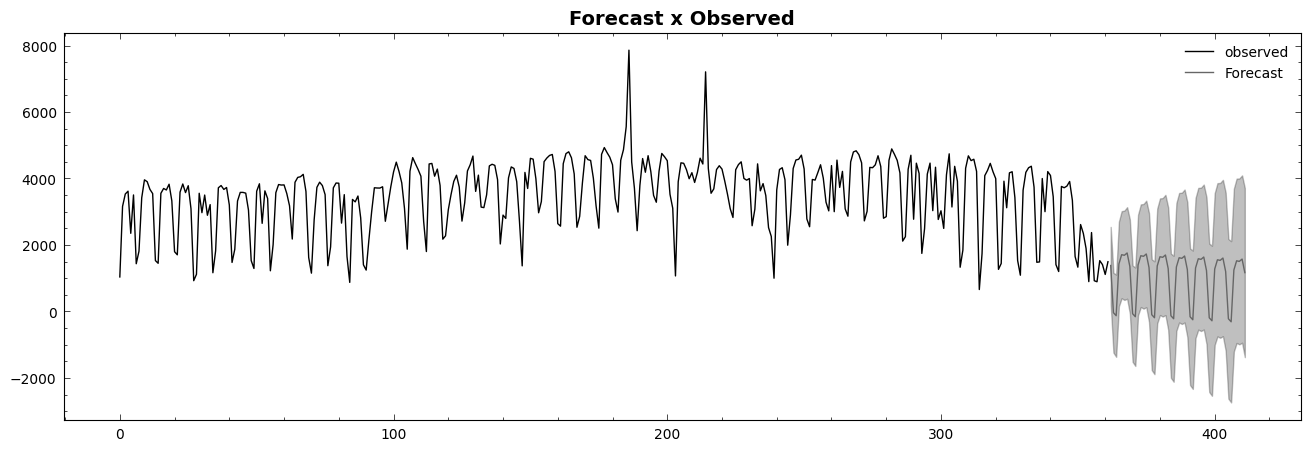

In [ ]:
ax = df['cnt'].plot(label='observed', figsize=(15, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_title('Forecast x Observed')
plt.legend()
plt.show()

## Modelos SARIMAX

Na seção anterior discutimos modelos SARIMA como uma extensão dos modelos ARIMA de modo a considerar o efeito da sazonalidade. No entanto, outras generalizações ainda são viáveis como a possibilidade de levar em consideração variáveis explicativas para melhorar o ajuste do modelo. Neste contexto surgem os modelos denominados SARIMAX onde o **X** se refere a variáveis denominadas e**X**ógenas. 

Variáveis exógenas são variáveis externas ou explicativas que podem servir como inputs adicionais de modo a prever ou entender variações nos sistemas estudados. Exemplos de variáveis exógenas são:
* Indicadores econômicos: o produto interno bruto (PIB), taxas de desemprego, inflação etc, podem ser considerados como variáveis exógenas em séries de mofdelagem econômica.
* Variáveis climáticas: temperatura, precipitação, umidade relativa do ar podem ser variáveis exógenas em séries que se propõe a modelar por exemplo a produção de energia em um país de matriz energética como a do Brasil. 
* Variáveis de datas e feriados: feriados costumam impactar positivamente e negativamente a quantidade de vendas e participação de eventos. 

Estes são apenas alguns exemplos de variáveis que podem ser consideradas exógenas mas o seu uso requer na maioria das vezes um conhecimento significativo do negócio, de modo a estabelecer uma hipóteses sobre a influência dessa variável na série a ser modelada. Vale sempre enfatizar que a ausência de entendimento pode eventualmente levar a inferências equivocadas, como no caso das chamadas correlações espúrias. 

A modelagem de modelos SARIMAX  utilizando variáveis exógenas é muito similar a modelagem de modelos SARIMA. Nas próximas seções iremos discutir essa modelagem através de exemplos práticos em Python. 

### SARIMAX com Python (hands-on)

Vamos começar agora lendo um novo conjunto de dados. Estes dados consistem em índices de consumo, renda, produção, economias e desemprego para a população americana no período que compreende o intervalo entre os anos de 1970 a 2016. 

In [ ]:
df = pd.read_csv(path + 'uschange.csv',parse_dates=True)
df

,Date,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.615986,0.972261,-2.452700,4.810312,0.9
1,1970 Q2,0.460376,1.169085,-0.551525,7.287992,0.5
2,1970 Q3,0.876791,1.553271,-0.358708,7.289013,0.5
3,1970 Q4,-0.274245,-0.255272,-2.185455,0.985230,0.7
4,1971 Q1,1.897371,1.987154,1.909734,3.657771,-0.1
...,...,...,...,...,...,...
182,2015 Q3,0.664970,0.801663,0.380606,3.180930,-0.3
183,2015 Q4,0.561680,0.740063,-0.845546,3.482786,0.0
184,2016 Q1,0.404682,0.519025,-0.417930,2.236534,0.0
185,2016 Q2,1.047707,0.723721,-0.203319,-2.721501,-0.1


Observe que neste caso a coluna **Date** precisa ser transformada para o formato datetime, e também para o índice do dataframe. No entanto a tranformação em datetime neste caso se torna ligeiramente mais complexa, onde precisamos separar a informação do quarter (Q1,Q2,Q3,Q4) do ano em questão e colocar um hífen entre as duas informações para que a instrução datetime possa executar. Isso feito, podemos converter a coluna **Date** para o índice do dataframe.

In [ ]:
df['date'] = pd.to_datetime( df['Date'].str[:4] + "-"+ df['Date'].str[-2:])

In [ ]:
df = df.set_index("date")

In [ ]:
df

,Date,Consumption,Income,Production,Savings,Unemployment
date,,,,,,
1970-01-01,1970 Q1,0.615986,0.972261,-2.452700,4.810312,0.9
1970-04-01,1970 Q2,0.460376,1.169085,-0.551525,7.287992,0.5
1970-07-01,1970 Q3,0.876791,1.553271,-0.358708,7.289013,0.5
1970-10-01,1970 Q4,-0.274245,-0.255272,-2.185455,0.985230,0.7
1971-01-01,1971 Q1,1.897371,1.987154,1.909734,3.657771,-0.1
...,...,...,...,...,...,...
2015-07-01,2015 Q3,0.664970,0.801663,0.380606,3.180930,-0.3
2015-10-01,2015 Q4,0.561680,0.740063,-0.845546,3.482786,0.0
2016-01-01,2016 Q1,0.404682,0.519025,-0.417930,2.236534,0.0


Observe que agora todas as colunas são indexadas e podem ser acessadas pela data de início de cada trimestre.

Para estudarmos o comportamento das variáveis exógenas podemos iniciar verificando se a variável exógena renda (Income), pode auxiliar no ajuste da variável endógena consumo (Consumption). Para facilitar vamos nos referir aos nomes originais das colunas em inglês.

O gráfico nos permite visualizar o comportamento histórico destas duas séries.

<Figure size 1500x500 with 0 Axes>

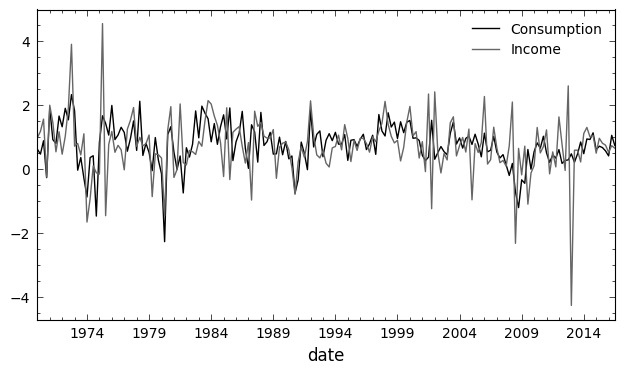

In [ ]:
plt.figure(figsize=(15,5))
df[['Consumption','Income']].plot()
plt.show();

Seguindo os mesmos procedimentos de análise da seção anterior, podemos utilizar o teste de Dickey Fuller para verificar se as duas séries possuem tendência.

In [ ]:
adf_test(df['Consumption'])

Resultados do Testes de Dickey-Fuller:
Test Statistic                  -4.522487
p-value                          0.000179
#Lags Used                       2.000000
Number of Observations Used    184.000000
Critical Value (1%)             -3.466398
Critical Value (5%)             -2.877380
Critical Value (10%)            -2.575214
dtype: float64


In [ ]:
adf_test(df['Income'])

Resultados do Testes de Dickey-Fuller:
Test Statistic                -1.515469e+01
p-value                        6.720576e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


Observando os **p-value** para o resultado dos dois testes, podemos concluir que as duas séries são estacionárias, o que pode ser verificado também a partir da decomposição erro, tendência e sazonalidade:

<Figure size 1000x500 with 0 Axes>

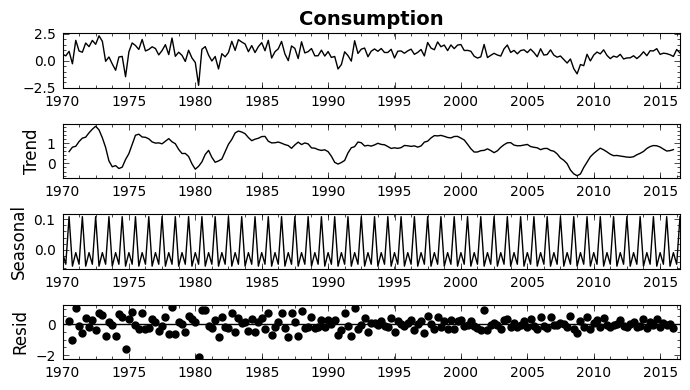

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
result = seasonal_decompose(df['Consumption'])
result.plot();

<Figure size 1000x500 with 0 Axes>

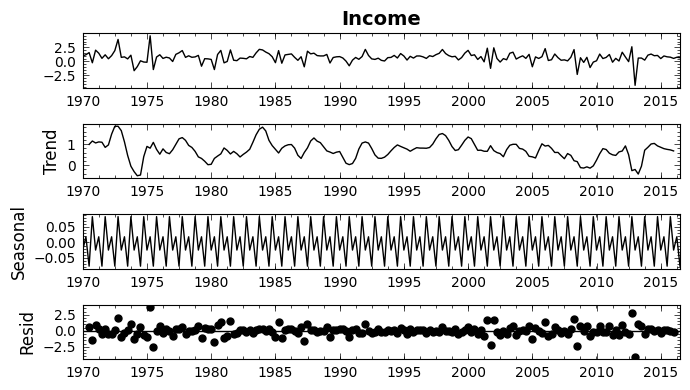

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
result = seasonal_decompose(df['Income'])
result.plot();

Logo como podemos verificar acima as duas séries são estacionárias. Um ponto importante de se observar aqui, é que embora apareça a componente sazonal na decomposição, as escalas dessa sazonalidade são demasiadamente pequenas, fazendo com que possam ser desconsideradas. De qualquer forma, como estaremos utilizando a biblioteca pmdarima para varrer o espaço de parâmetros, podemos em princípio pedir que ele ajuste um modelo SARIMA, mantendo a expectativa de que (P,D,Q) = (0,0,0). O valor de m=4 no entanto, pode ser encontrado através do gráfico que parece demonstrar uma componente sazonal anual, dado que os dados estão divididos por quarters ou trimestres (Q1,Q2,Q3,Q4). 

Dado essa estacionariedade utilizaremos a função auto_arima para varrer o espaço de parâmetros e encontrar os valores (p,d,q) × (P,D,Q)(4), para a série Consumption, em princípio sem contabilizar o efeito de qualquer variável exógena. Assim, poderemos comparar a série ajustada sem e com variáveis explicativas.

In [ ]:
auto_arima(df['Consumption'],seasonal=True,m=4, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=343.154, Time=2.26 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=375.632, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=355.235, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=361.078, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=529.744, Time=0.09 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=342.517, Time=2.53 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=342.284, Time=0.91 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=343.093, Time=2.51 sec
 ARIMA(1,0,2)(0,0,0)[4] intercept   : AIC=343.330, Time=0.50 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=344.493, Time=0.58 sec
 ARIMA(3,0,2)(0,0,0)[4] intercept   : AIC=342.536, Time=0.67 sec
 ARIMA(2,0,3)(0,0,0)[4] intercept   : AIC=343.179, Time=0.92 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=343.815, Time=0.31 sec
 ARIMA(1,0,3)(0,0,0)[4] intercept   : AIC=341.613, Time=0.54 sec
 ARIMA(1,0,3)(1,0,0)[4] intercept   : AIC=343.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -164.807
Date:                Tue, 04 Apr 2023   AIC                            341.613
Time:                        06:13:31   BIC                            361.000
Sample:                    01-01-1970   HQIC                           349.469
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3066      0.096      3.199      0.001       0.119       0.494
ar.L1          0.5887      0.132      4.458      0.000       0.330       0.847
ma.L1         -0.3529      0.138     -2.552      0.011      -0.624      -0.082
ma.L2          0.0846      0.065      1.309      0.190      -0.042       0.211
ma.L3          0.1738      0.079      2.214      0.027       0.020       0.328
sigma2         0.3405      0.025     13.646      0.000       0.292       0.389
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                64.65
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dessa forma, obtemos que os parâmetros (1,0,3)x(0,0,0,4) constituem de acordo com o critério de Akaike (AIC) o conjunto mais apropriado para a série estudada.Observe também que conforme o esperado o valor das componentes sazonais são zero. A partir disso, podemos proceder o ajuste do modelo:

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['Consumption'],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -174.305
Date:                Tue, 04 Apr 2023   AIC                            358.611
Time:                        06:13:32   BIC                            374.766
Sample:                    01-01-1970   HQIC                           365.157
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9348      0.037     25.477      0.000       0.863       1.007
ma.L1         -0.6069      0.059    -10.370      0.000      -0.722      -0.492
ma.L2          0.0526      0.062      0.850      0.395      -0.069       0.174
ma.L3          0.0723      0.069      1.048      0.295      -0.063       0.208
sigma2         0.3752      0.029     12.936      0.000       0.318       0.432
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                30.74
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A partir do objeto **results** criado acima, podemos predizer os valores para uma determinado intervalo de tempo e medir a qualidade do ajuste através de métricas como o MSE, RMSE ou qualquer outra mais conveniente.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['Consumption'],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -174.305
Date:                Tue, 04 Apr 2023   AIC                            358.611
Time:                        06:13:32   BIC                            374.766
Sample:                    01-01-1970   HQIC                           365.157
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9348      0.037     25.477      0.000       0.863       1.007
ma.L1         -0.6069      0.059    -10.370      0.000      -0.722      -0.492
ma.L2          0.0526      0.062      0.850      0.395      -0.069       0.174
ma.L3          0.0723      0.069      1.048      0.295      -0.063       0.208
sigma2         0.3752      0.029     12.936      0.000       0.318       0.432
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                30.74
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Com os resultados do modelo, podemos proceder da mesma forma que na seção anterior verificando as predições e comparando com os valores observados para a série. Note no entanto, que agora, para o parâmetro start, estaremos utilizando a data ao invés do índice, o que no geral é muito mais conveniente: 

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2012-Q3'), dynamic=False)

Calculando os intervalos de confiança temos que:

In [ ]:
pred_ci = pred.conf_int()

E graficando as previsões com o observado:

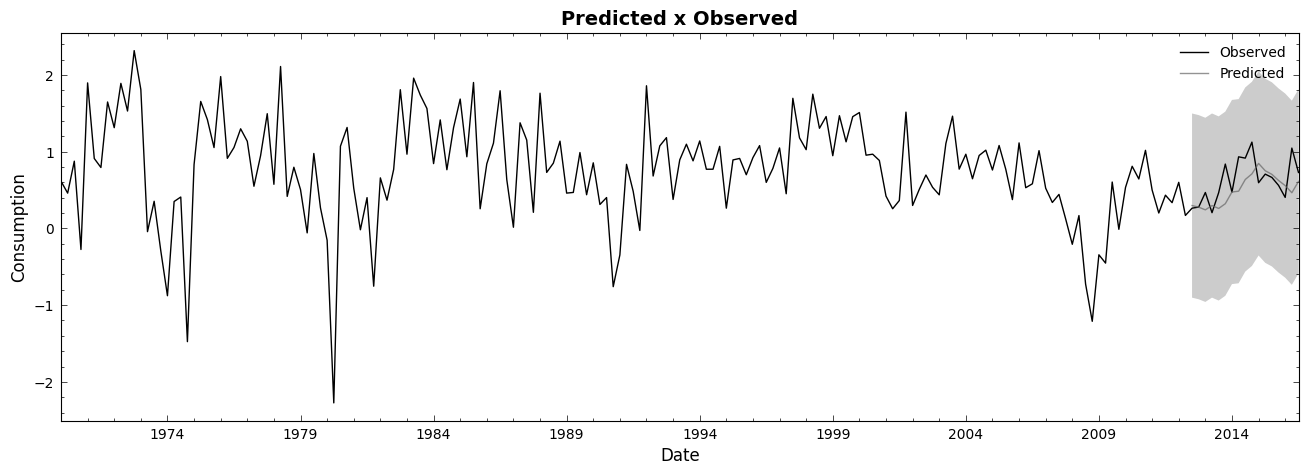

In [ ]:
plt.figure(figsize=(15,5))
ax = df['Consumption'].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
ax.set_title('Predicted x Observed')
plt.legend()

plt.show()

Calculando as métricas, temos que?

In [ ]:
from statsmodels.tools.eval_measures import mse,rmse, meanabs
reals = df['2012-Q3':]['Consumption']
error1 = mse(pred.predicted_mean, reals)
error2 = rmse(pred.predicted_mean, reals)
error3 = meanabs(pred.predicted_mean, reals)
print(f'SARIMA(1,0,3)(0,0,0,4) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,3)(0,0,0,4) RMSE Error: {error2:11.10}')
print(f'SARIMA(1,0,3)(0,0,0,4) MAE Error: {error2:11.10}')

SARIMA(1,0,3)(0,0,0,4) MSE Error: 0.07455724994
SARIMA(1,0,3)(0,0,0,4) RMSE Error: 0.2730517349
SARIMA(1,0,3)(0,0,0,4) MAE Error: 0.2730517349


### Adicionando a variável exógena ao modelo SARIMA

Na seção anterior, utilizamos o comando SARIMAX para fazer o ajuste (**.fit**) do modelo, apesar de não termos especificado qual variável usaríamos. Dentro do contexto da biblioteca statsmodel, adicionar a variável exógena é bastante simples, bastando adicionar **exog=df[[variável1,variável2,...]]** como parâmetro do comando. Desta forma, vamos aproveitar o resultado da seção anterior acrescentando primeiro a coluna **Income** e depois as demais colunas em conjunto. 

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


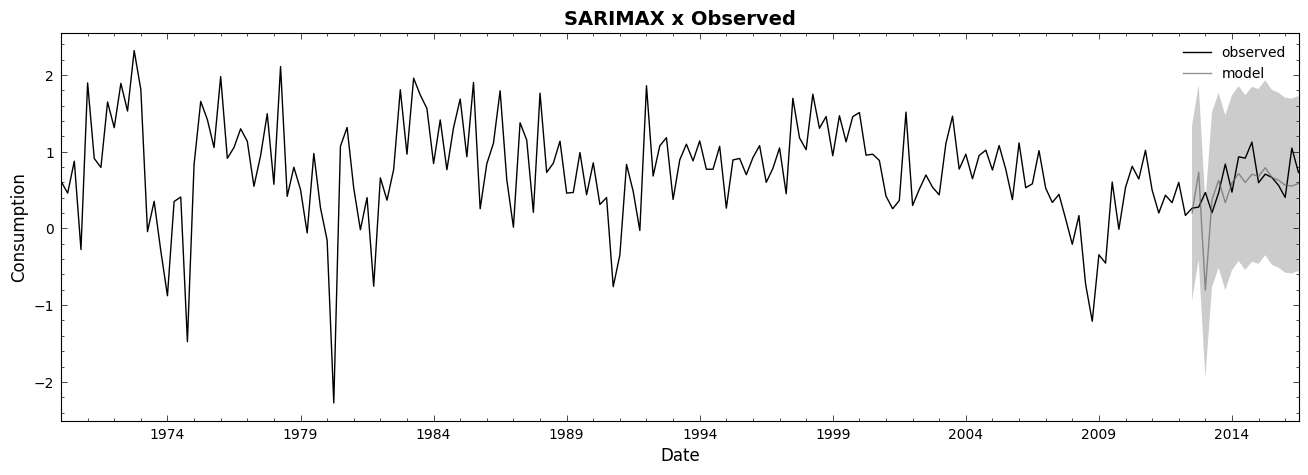

In [ ]:
model = SARIMAX(df['Consumption'],exog=df[['Income']],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False)
results = model.fit()
results.summary()

plt.figure(figsize=(15,5))
pred = results.get_prediction(start=pd.to_datetime('2012-Q3'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['Consumption'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='model', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
ax.set_title('SARIMAX x Observed')
plt.legend()

plt.show();

Observando então as métricas temos que:

In [ ]:
from statsmodels.tools.eval_measures import mse,rmse
reals = df['2012-Q3':]['Consumption']
error1 = mse(pred.predicted_mean, reals)
error2 = rmse(pred.predicted_mean, reals)

print(f'SARIMA(1,0,3)(0,0,0,4) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,3)(0,0,0,4) RMSE Error: {error2:11.10}')

SARIMA(1,0,3)(0,0,0,4) MSE Error: 0.163615332
SARIMA(1,0,3)(0,0,0,4) RMSE Error: 0.4044939208


Note que acrescentar uma única variável no sistema, não necessariamente implica em um ajuste melhor. No nosso exemplo o RMSE por exemplo varia de 0.27 para 0.40 no caso de incluirmos a variável Income. Vale destacar que nesse caso não nos preocupamos em utilizar nenhum método de seleção de variáveis, dado que estaria além do escopo a que nos propomos aqui, e apenas acrescentamos arbitrariamente os valores de uma nova coluna.

A título de curiosidade vamos acrescentar as demais colunas (Income, Production, Savings,Unemployment) e verificar através da mesma métrica, a qualidade do ajuste:

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


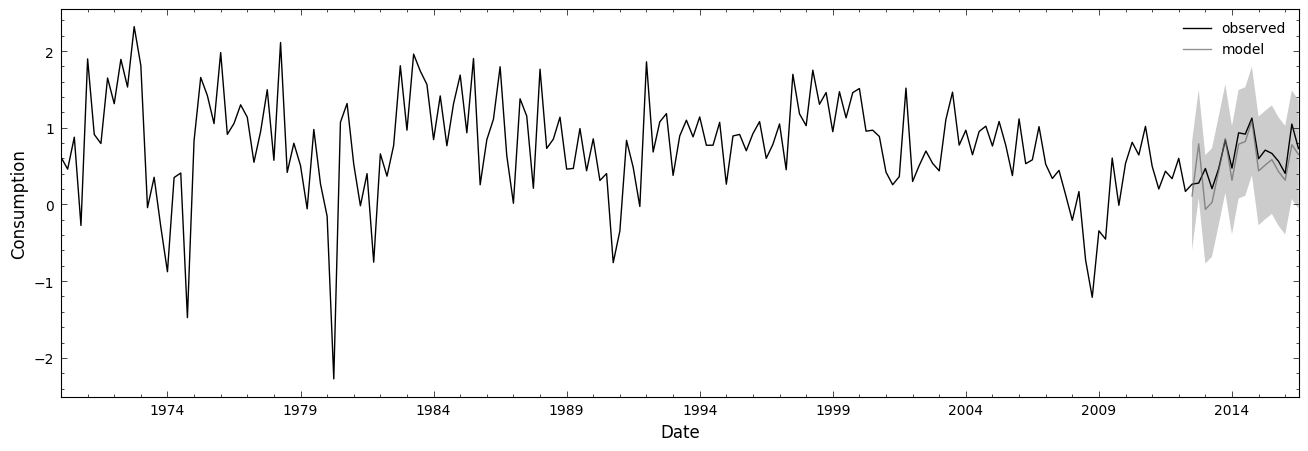

In [ ]:
model = SARIMAX(df['Consumption'],exog=df[['Income','Production','Savings','Unemployment']],order=(1,0,3),seasonal_order=(0,0,0,4),enforce_invertibility=False);
results = model.fit();
results.summary();

plt.figure(figsize=(15,5))
pred = results.get_prediction(start=pd.to_datetime('2012-Q3'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['Consumption'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='model', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.legend()

plt.show();

In [ ]:
from statsmodels.tools.eval_measures import mse,rmse
reals = df['2012-Q3':]['Consumption']
error1 = mse(pred.predicted_mean, reals)
error2 = rmse(pred.predicted_mean, reals)

print(f'SARIMA(1,0,3)(0,0,0,4) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,3)(0,0,0,4) RMSE Error: {error2:11.10}')

SARIMA(1,0,3)(0,0,0,4) MSE Error: 0.0491086718
SARIMA(1,0,3)(0,0,0,4) RMSE Error: 0.2216047648


Observe que agora obtivemos para a mesma métrica, o RMSE, um valor ainda melhor. Esse exercício nos permite assim concluir que não existe uma receita simples e definitva para melhorar a qualidade do ajuste, como simplesmente adicionar variáveis exógenas adicionais. A utilização de modelos SARIMAX requer uma análise exploratória detalhada dos dados, assim como a experimentação de diversos valores de parâmetros de modo a escolher o valor mais apropriado para o ajuste. 

Uma outra limitação dos modelos SARIMAX pode ser melhor entendida se tentamos fazer o forecast para os próximos 15 pontos no gráfico:

In [ ]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=15)

ValueError: ignored

Note que a mensagem **ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument** é de certa forma auto-explicativa. Como não temos o intervalo futuro (próximos 15 pontos) para as variáveis exógenas (Income, Production, Savings,Unemployment), nós não conseguimos fazer o forecast desejado. Caso tivéssemos precisaríamos passar este parâmetro como argumento da função **get_forecast** como no seguinte exemplo: 


```
pred_uc = results.get_forecast(steps=15, exog= df_exog)
```
onde **df_exog** precisaria ser um dataframe com 4 colunas (Income, Production, Savings,Unemployment) e 15 linhas (próximos 15 pontos do gráfico). No nosso exemplo, seria necessário fazer o forecast para 15 pontos de cada uma das séries exógenas individualmente, e a partir disso acrescentar essas previsões de modo a compor a nossa previsão de interesse. É imediato perceber que isso acrescentaria um erro muito grande na previsão.  

Um exemplo muito comum para o uso deste tipo de modelagem é por exemplo quando queremos fazer um forecast para prever vendas ao longo das próximas duas semanas. Neste caso poderíamos utilizar como variável exógena se um determinado dia da semana é feriado ou não. Nesse caso seria relativamente fácil obter o dataframe **df_exog** com uma coluna de valores 0 ou 1 no caso do dia ser feriado sim ou não respectivamente. De fato, esse é um procedimento relativamente comum e existe inclusive uma biblioteca em python que calcula os feriados denominada **holiday**. Você pode obter mais detalhes acessando [aqui](https://pypi.org/project/holidays/).


# Outros modelos com sazonalidade

Neste capítulo você pode perceber que a inclusão da sazonalidade insere uma complexidade significativa nos modelos ARIMA, através dos parâmetros $(P,D,Q)$. Neste sentido, é importante adicionar que algumas séries mais complexas possuem componentes de sazonalidade múltipla, onde podemos ter eventos que se repetem ao longo de semanas por exemplo, enquanto outros eventos podem se repetir anualmente. 

Ao longo do tempo, diversos modelos foram desenvolvidos de modo a se tornarem uma opção em relação a séries mais complexas. O modelo VAR por exemplo é uma sigla para Vector Autoregression, que pode ser aplicado no caso da análise de séries temporais multivariadas. Este modelo permite modelar a dinâmica entre variáveis que interagem mutuamente. Do ponto de vista prático esse modelo considera as correlações dos valores das séries com os seus próprios lags, mas também com os lags das outras variáveis. Pode ser muito útil na modelagem de séries multivariadas. 

Outro modelo que merece consideração é o modelo chamado TBATS, "Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend, and Seasonal components" em inglês, que em português pode ser traduzido como "Sazonalidade trigonométrica, transformação Box-Cox, erros ARMA, tendência e componentes sazonais". Este modelo é uma extensão dos modelos ARIMA de modo a incorporar sazonalidades complexas e múltiplas. 

Mais recentemente(2017) no entanto, foi desenvolvido pela Meta o modelo denominado Prophet. O prophet é um modelo aditivo onde as componentes levam em conta as considerações de datas e feriados de acordo com os calendários locais dos países. O modelo Prophet também é robusto a mudanças abruptas na tendência e nas sazonalidades, e pode lidar com feriados que não ocorrem regularmente, como feriados móveis e feriados que variam de ano para ano.

No capítulo 6, iremos explorar como modelos de machine learning já conhecidos como Random Forest, XGBoost, etc podem gerar previsões acuradas para séries temporais, tanto quanto os modelos da família ARIMA, discutidos nos 3 últimos capítulos. 

# Sumário

Os modelos Sazonais Autoregressivos integrado de médias móveis (SARIMA) são extensões de modelos ARIMA capazes de levar em conta o efeito da sazonalidade. Essa classe de modelos é capaz de lidar tanto com tendência como sazonalidade, parametrizando estes efeitos através dos parâmetros $(p,d,q)×(P,D,Q)_m$, onde as letras minúsculas se referem às componentes não sazonais e as maiúsculas às ordens dos termos sazonais. O ajuste dos modelos SARIMA acontecem através da escolha destes parâmetros, utilizando uma combinação de informações, como as provenientes dos gráficos de ACF e PACF, assim como da análise do critério de Akaike (AIC ou BIC). 

Além disso, abordamos neste capítulo os modelos SARIMAX onde a letra "X" se refere à possibilidade de fazermos uso de variáveis exógenas ou explicativas para a melhoria da qualidade do ajuste (se possível). 

A seguir, encontram-se as principais funções que devem ser implementadas para a construçãos dos modelos SARIMA ou SARIMAX usando a biblioteca statsmodel.
$$
\begin{array}{|c|c|c|}
\hline \text { Modelo } & \text { Código } & \text { Quando aplicar } \\
\hline SARIMA & \text { SARIMA(dados, order=(p, d, q), seasonal_order=(P,D,Q,m) }) . \text { fit }() . \text { summary }() & \text { Séries não estacionárias com sazonalidade } \\
\hline SARIMAX & \text { SARIMAX(dados, exog=dados[[exog1,...,exogn]], order=(p, d, q), seasonal_order=(P,D,Q,m) }) . \text { fit }() . \text { summary }() & \text { Séries não estacionárias com sazonalidade} \\
\hline
\end{array}
$$

Para ajustar um modelo SARIMAX, é necessário escolher os valores apropriados para os parâmetros SARIMA, bem como identificar as variáveis exógenas relevantes e incluí-las no modelo. A seleção das variáveis exógenas pode ser feita por meio de técnicas estatísticas, como a análise de correlação.


Em resumo, o modelo SARIMA é usado para prever valores futuros de séries temporais que possuem tendência e sazonalidade, enquanto o modelo SARIMAX permite a inclusão de variáveis exógenas na previsão. 



# Para Saber Mais

Para aprofundar no tema das Séries Temporais Sazonais você pode buscar por:

* MORETTIN, Pedro A.; TOLOI, Clélia. **Análise de séries temporais.** In: Análise de séries temporais. 2006. p. 538-538.

* Souza, Reinaldo C.; Camargo, Maria Emilia. **Análise e Previsão de séries temporais.**. 2004. p. 145-158.


Entretanto para os modelos mais complexos, você pode buscar por:
<br>

* HYNDMAN, Rob J.; ATHANASOPOULOS, George. Forecasting: principles and practice. OTexts, 2018. Disponível em: https://otexts.com/fpp3/

O livro dedica uma seção para modelos de sazonalidade complexa e discute tanto sobre os modelos Porphet e VAR. 